In [ ]:
# 09_Practice

In [164]:
# 필요한 라이브러리 임포트
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, isnan, corr
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import PCA
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [188]:
import pyspark
from pyspark.sql.types import StringType, BooleanType, NumericType
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, count, when, isnan, corr
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

In [166]:
# 1. Spark 세션 시작
spark = SparkSession.builder.appName("EmployeeAttritionPrediction").getOrCreate()

# 데이터 로드
file_path = 'learning_spark_data/WA_Fn-UseC_-HR-Employee-Attrition.csv'
df = spark.read.csv(file_path, header=True, inferSchema=True)

In [90]:
type(df)

pyspark.sql.dataframe.DataFrame

In [91]:
# 전체 데이터 행 수 확인
print(f"\n전체 직원 수: {df.count()}")


전체 직원 수: 1470


In [92]:
# 전체 feature 수 확인
columns = df.columns
num_features = len(columns)
print(f"전체 feature 수: {num_features}")

전체 feature 수: 35


In [93]:
# 데이터 스키마 확인
print("--- 데이터 스키마 ---")
df.printSchema()

--- 데이터 스키마 ---
root
 |-- Age: integer (nullable = true)
 |-- Attrition: string (nullable = true)
 |-- BusinessTravel: string (nullable = true)
 |-- DailyRate: integer (nullable = true)
 |-- Department: string (nullable = true)
 |-- DistanceFromHome: integer (nullable = true)
 |-- Education: integer (nullable = true)
 |-- EducationField: string (nullable = true)
 |-- EmployeeCount: integer (nullable = true)
 |-- EmployeeNumber: integer (nullable = true)
 |-- EnvironmentSatisfaction: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- HourlyRate: integer (nullable = true)
 |-- JobInvolvement: integer (nullable = true)
 |-- JobLevel: integer (nullable = true)
 |-- JobRole: string (nullable = true)
 |-- JobSatisfaction: integer (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- MonthlyIncome: integer (nullable = true)
 |-- MonthlyRate: integer (nullable = true)
 |-- NumCompaniesWorked: integer (nullable = true)
 |-- Over18: string (nullable = true)
 |-- O

In [94]:
### 2단계: 결측치(Missing Values) 확인
# 데이터에 누락된 값이 있는지 확인합니다. 결측치가 많으면 모델 성능에 큰 영향을 미치므로 반드시 처리해야 합니다.

from pyspark.sql.functions import col, count, when, isnan

print("--- 컬럼별 결측치 개수 ---")

# 방법 1: 각 컬럼별 결측치 개수를 세로로 출력
for column in df.columns:
    missing_count = df.filter(col(column).isNull() | isnan(col(column))).count()
    print(f"{column}: {missing_count}")

print("\n--- 결측치가 있는 컬럼만 표시 ---")

# 방법 2: 결측치가 있는 컬럼만 필터링해서 출력
missing_info = []
for column in df.columns:
    missing_count = df.filter(col(column).isNull() | isnan(col(column))).count()
    if missing_count > 0:
        missing_info.append((column, missing_count))

if missing_info:
    for column, count in missing_info:
        print(f"{column}: {count}")
else:
    print("결측치가 있는 컬럼이 없습니다.")

print("\n--- 전체 데이터 대비 결측치 비율 ---")

# 방법 3: 결측치 비율도 함께 표시
total_rows = df.count()
for column in df.columns:
    missing_count = df.filter(col(column).isNull() | isnan(col(column))).count()
    if missing_count > 0:
        missing_ratio = (missing_count / total_rows) * 100
        print(f"{column}: {missing_count} ({missing_ratio:.2f}%)")

# 방법 4: 결측치 요약 정보
print("\n--- 결측치 요약 ---")
total_columns = len(df.columns)
columns_with_missing = sum(1 for column in df.columns 
                          if df.filter(col(column).isNull() | isnan(col(column))).count() > 0)
print(f"전체 컬럼 수: {total_columns}")
print(f"결측치가 있는 컬럼 수: {columns_with_missing}")
print(f"결측치가 없는 컬럼 수: {total_columns - columns_with_missing}")

--- 컬럼별 결측치 개수 ---
Age: 0
Attrition: 0
BusinessTravel: 0
DailyRate: 0
Department: 0
DistanceFromHome: 0
Education: 0
EducationField: 0
EmployeeCount: 0
EmployeeNumber: 0
EnvironmentSatisfaction: 0
Gender: 0
HourlyRate: 0
JobInvolvement: 0
JobLevel: 0
JobRole: 0
JobSatisfaction: 0
MaritalStatus: 0
MonthlyIncome: 0
MonthlyRate: 0
NumCompaniesWorked: 0
Over18: 0
OverTime: 0
PercentSalaryHike: 0
PerformanceRating: 0
RelationshipSatisfaction: 0
StandardHours: 0
StockOptionLevel: 0
TotalWorkingYears: 0
TrainingTimesLastYear: 0
WorkLifeBalance: 0
YearsAtCompany: 0
YearsInCurrentRole: 0
YearsSinceLastPromotion: 0
YearsWithCurrManager: 0

--- 결측치가 있는 컬럼만 표시 ---
결측치가 있는 컬럼이 없습니다.

--- 전체 데이터 대비 결측치 비율 ---

--- 결측치 요약 ---
전체 컬럼 수: 35
결측치가 있는 컬럼 수: 0
결측치가 없는 컬럼 수: 35


In [95]:
# Attrition (퇴사 여부) 분포 확인
print("--- 퇴사 여부(Attrition) 분포 ---")
df.groupBy('Attrition').count().show()

--- 퇴사 여부(Attrition) 분포 ---
+---------+-----+
|Attrition|count|
+---------+-----+
|       No| 1233|
|      Yes|  237|
+---------+-----+



In [96]:
# 범주형 컬럼: 문자열, 불리언 등
categorical_cols = [field.name for field in df.schema.fields 
                    if isinstance(field.dataType, (StringType, BooleanType))]

# 수치형 컬럼: 정수, 실수 등
numerical_cols = [field.name for field in df.schema.fields 
                  if isinstance(field.dataType, NumericType)]

print("Categorical Columns:", categorical_cols)
print(f"Categorical Columns 갯수 :{len(categorical_cols)}")
print("Numerical Columns:", numerical_cols)
print(f"Numerical Columns 갯수 :{len(numerical_cols)}")

Categorical Columns: ['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'OverTime']
Categorical Columns 갯수 :9
Numerical Columns: ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
Numerical Columns 갯수 :26


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 부서(Department)별 월급(MonthlyIncome) 분포를 박스 플롯으로 시각화
sns.boxplot(x='Department', y='Attrition', data=df)
plt.show()

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Attrition
An error occurred while plotting for column 'Attrition': 2

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
BusinessTravel


<Figure size 1000x800 with 0 Axes>

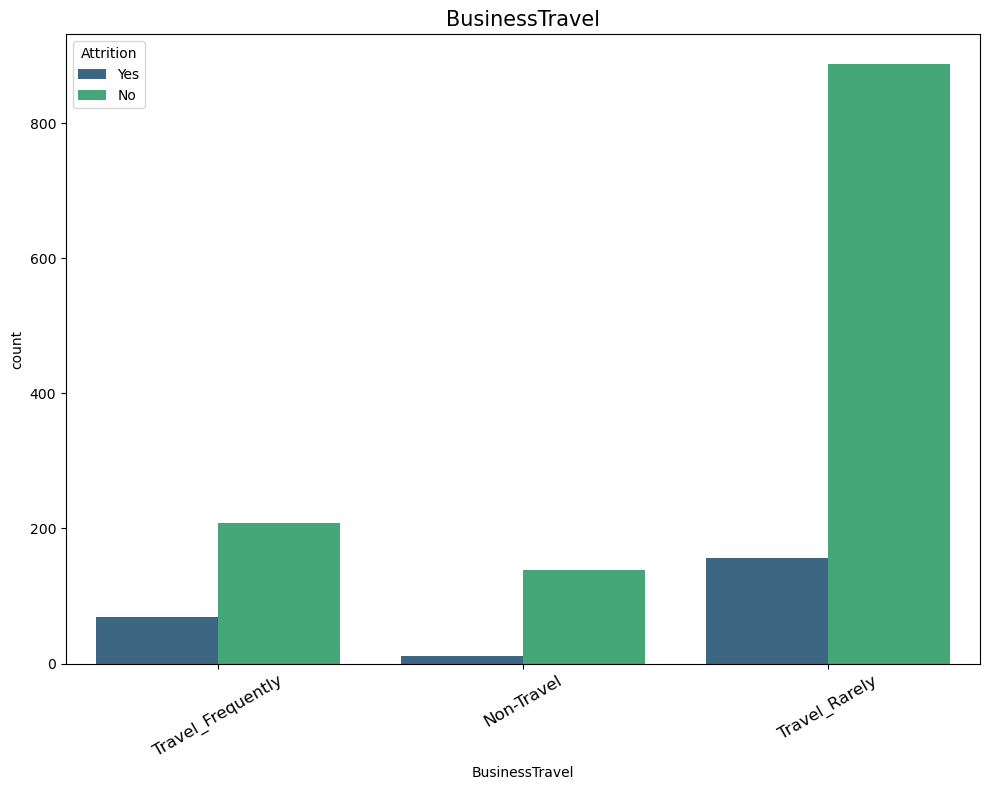

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Department


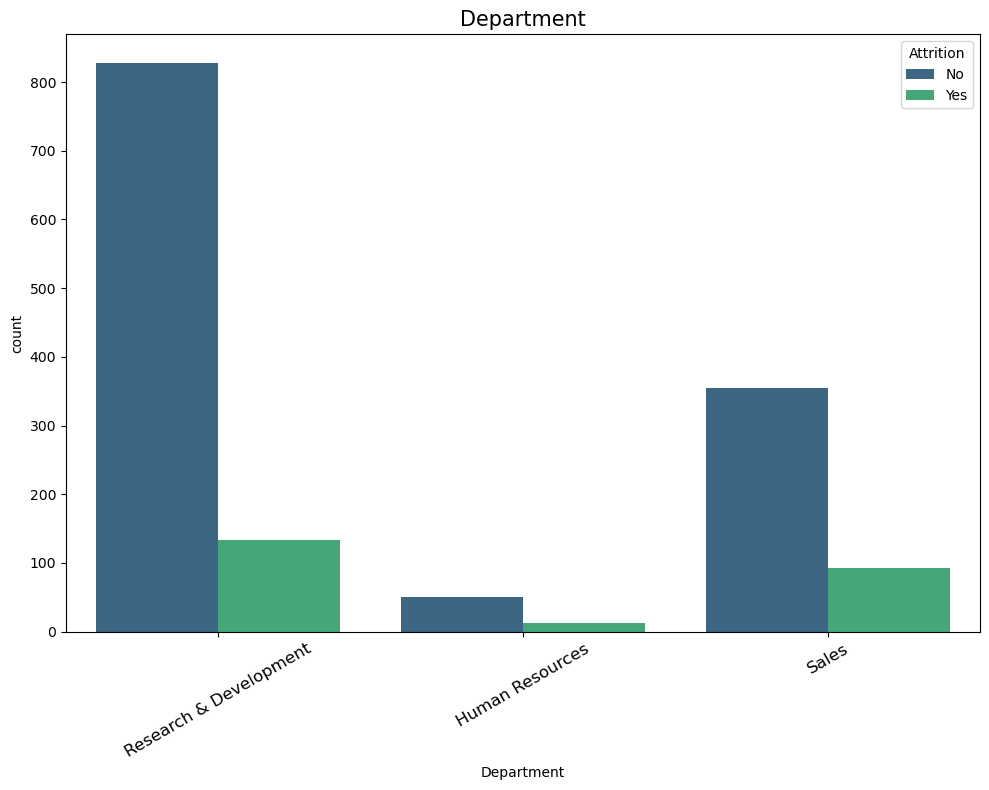

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
EducationField


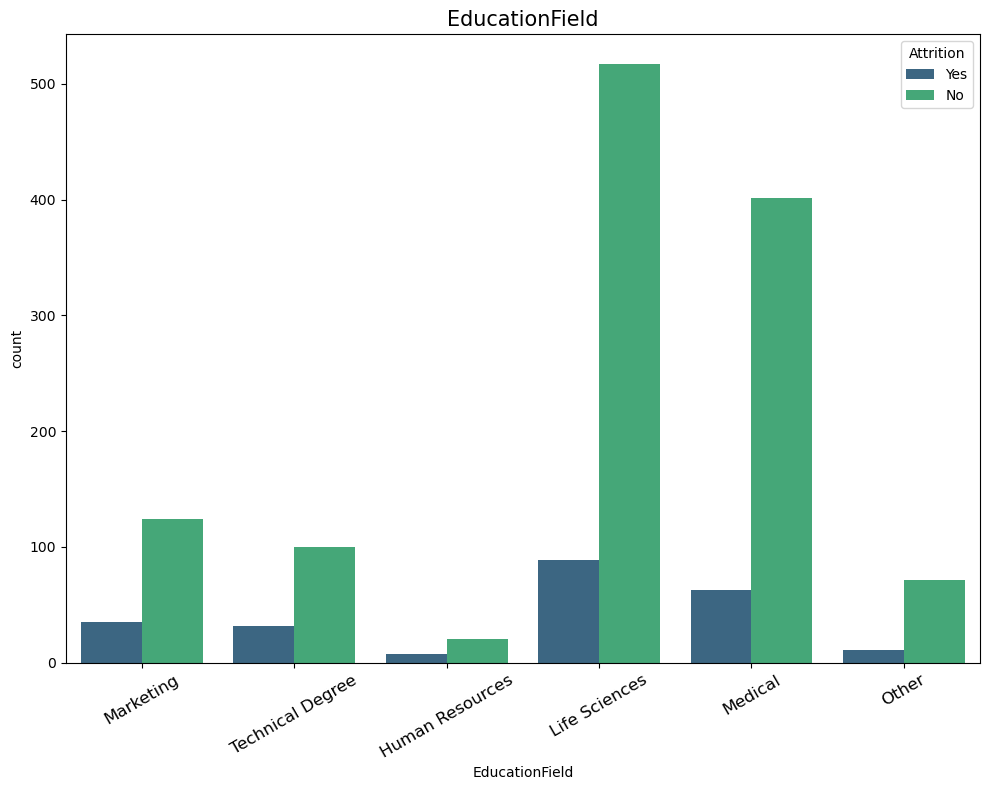

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Gender


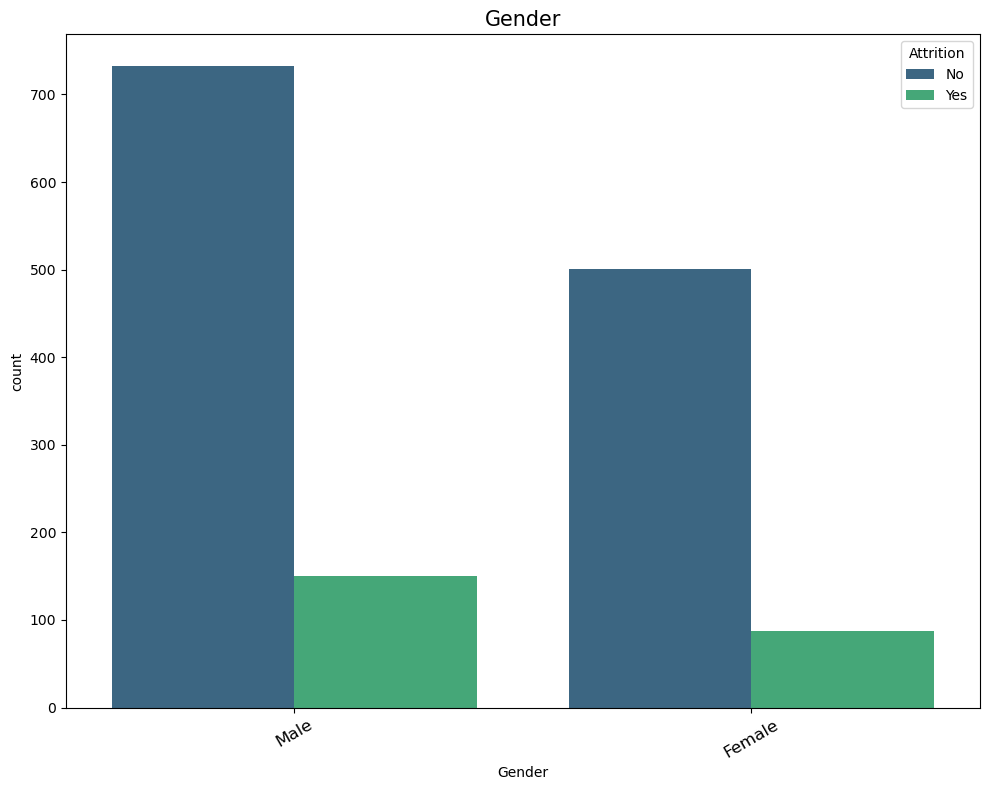

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
JobRole


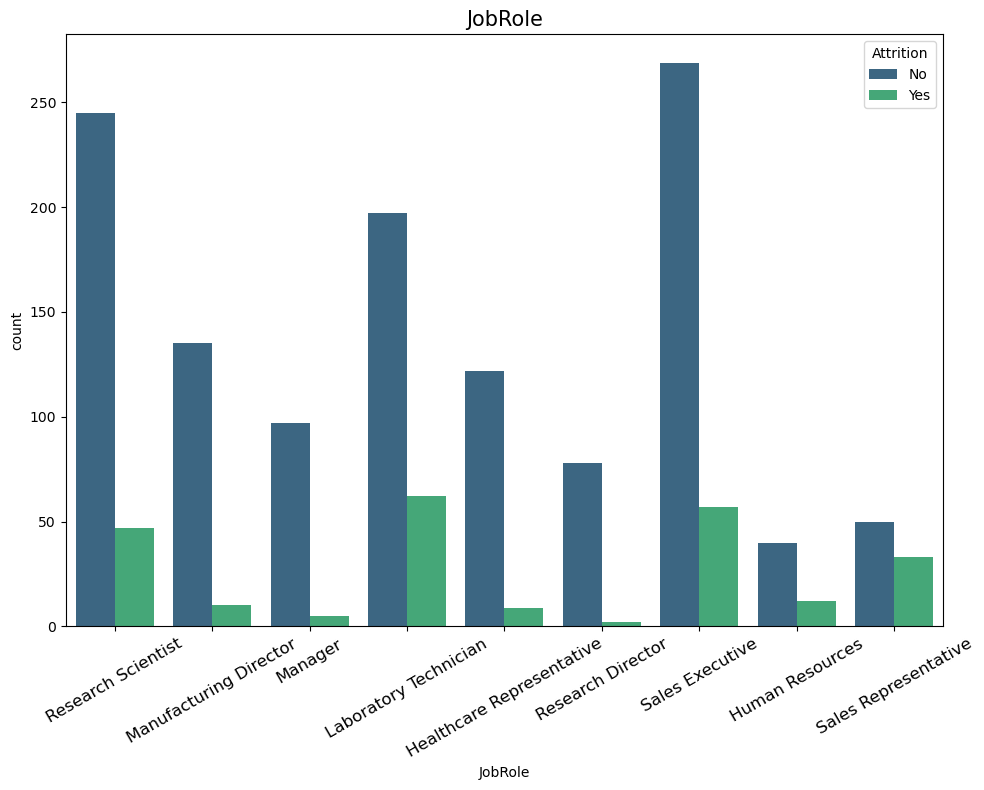

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
MaritalStatus


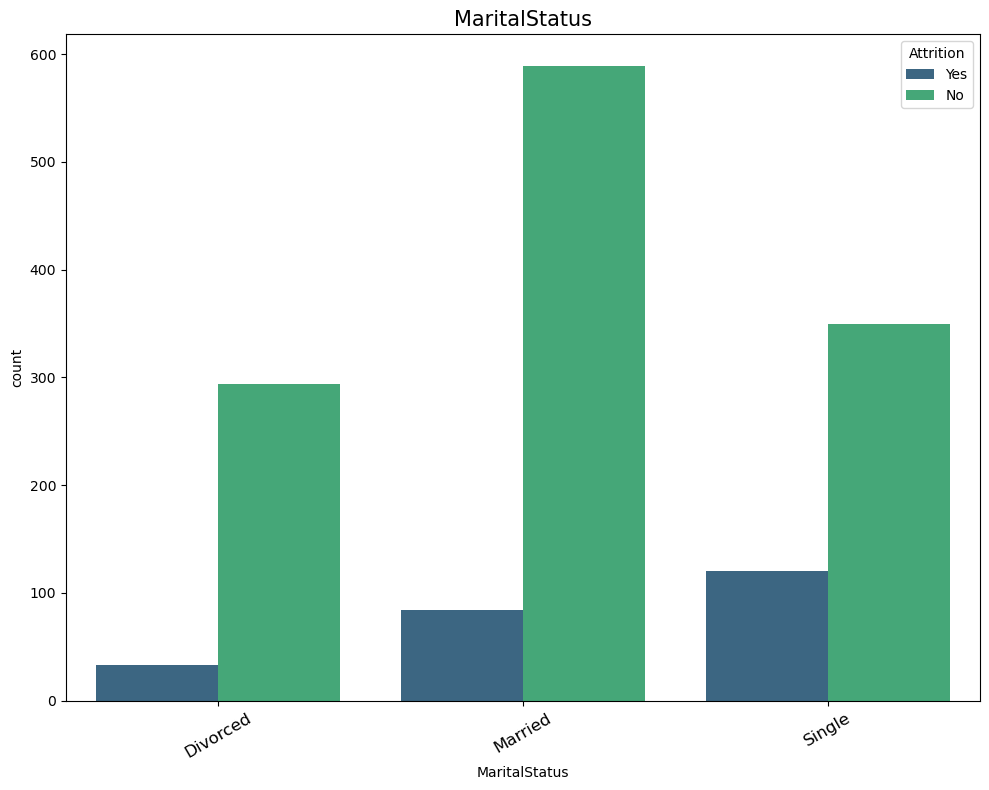

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Over18


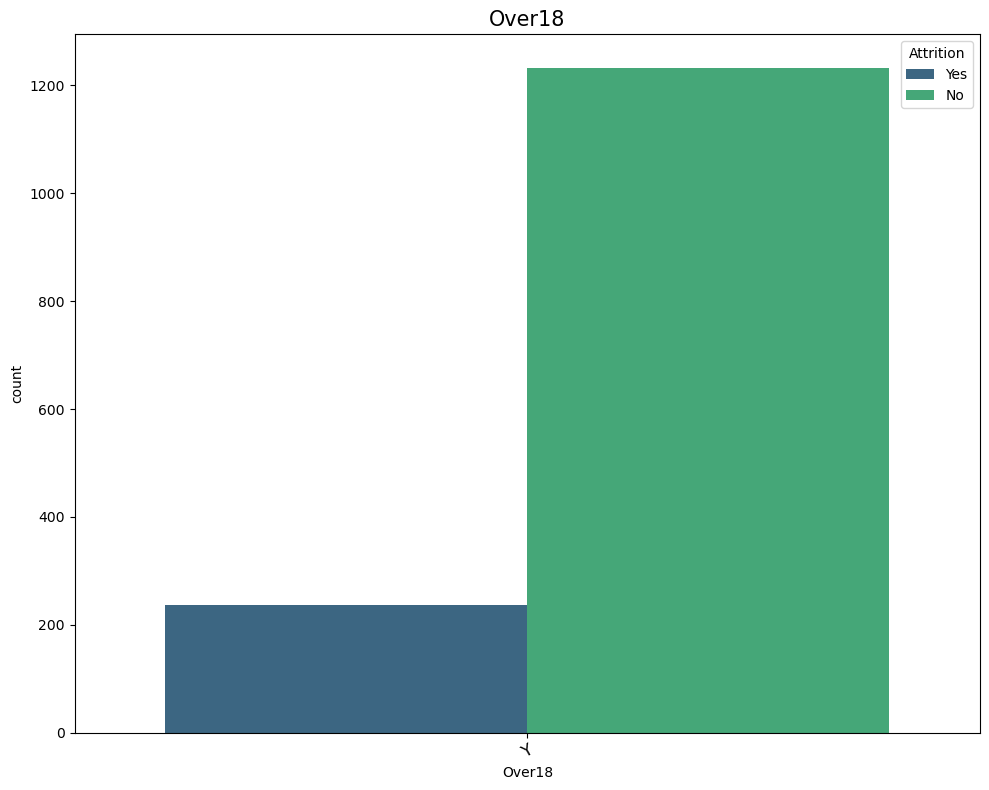

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
OverTime


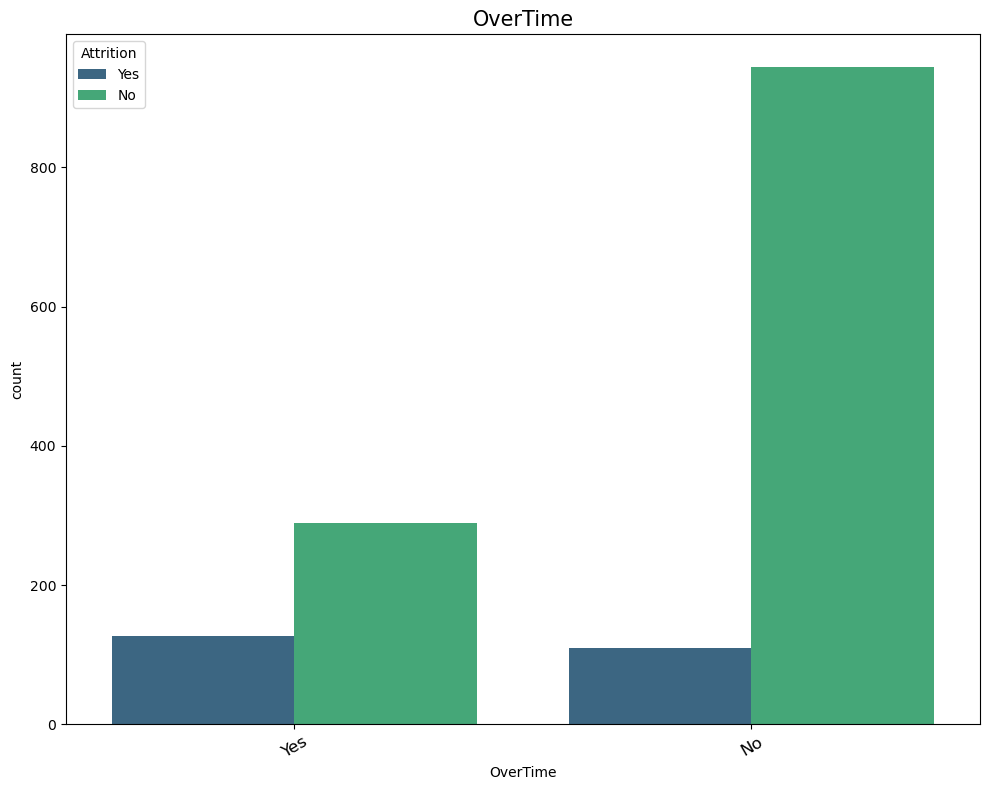

In [135]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
warnings.filterwarnings("ignore")

for column in categorical_features:
    # 어떤 컬럼을 처리 중인지 출력
    print('-'*200)
    print(column)
    
    try:
        # Spark 데이터 집계
        agg_df = df.groupBy(column, 'Attrition').count()
        pd_df = agg_df.toPandas()
        
        
        # 시각화
        if pd_df.empty:
            print(f"Warning: Data for {column} is empty. Skipping plot.")
            continue # 데이터가 비어있으면 다음 루프로 넘어감

        plt.figure(figsize=(10, 8))
        sns.barplot(x=column, y='count', hue='Attrition', data=pd_df, palette='viridis')
        plt.title(f'{column}', fontsize=15)
        plt.xticks(rotation=30,ha='center', fontsize = 12)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        # 5. 에러가 발생하면 어떤 에러인지 출력하고 멈추지 않고 계속 진행
        print(f"An error occurred while plotting for column '{column}': {e}\n")

In [140]:
# 범주형 데이터
print(len(categorical_cols))
print(categorical_cols)
for col in categorical_cols:
    df.groupBy(col).count().orderBy("count", ascending=False).show()

9
['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'OverTime']
+---------+-----+
|Attrition|count|
+---------+-----+
|       No| 1233|
|      Yes|  237|
+---------+-----+

+-----------------+-----+
|   BusinessTravel|count|
+-----------------+-----+
|    Travel_Rarely| 1043|
|Travel_Frequently|  277|
|       Non-Travel|  150|
+-----------------+-----+

+--------------------+-----+
|          Department|count|
+--------------------+-----+
|Research & Develo...|  961|
|               Sales|  446|
|     Human Resources|   63|
+--------------------+-----+

+----------------+-----+
|  EducationField|count|
+----------------+-----+
|   Life Sciences|  606|
|         Medical|  464|
|       Marketing|  159|
|Technical Degree|  132|
|           Other|   82|
| Human Resources|   27|
+----------------+-----+

+------+-----+
|Gender|count|
+------+-----+
|  Male|  882|
|Female|  588|
+------+-----+

+--------------------+-----+
|      

In [139]:
print(len(numerical_cols))
print(numerical_cols)
for col in numerical_cols:
    df.groupBy(col).count().orderBy("count", ascending=False).show()

26
['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
+---+-----+
|Age|count|
+---+-----+
| 35|   78|
| 34|   77|
| 31|   69|
| 36|   69|
| 29|   68|
| 32|   61|
| 30|   60|
| 38|   58|
| 33|   58|
| 40|   57|
| 37|   50|
| 28|   48|
| 27|   48|
| 42|   46|
| 39|   42|
| 45|   41|
| 41|   40|
| 26|   39|
| 44|   33|
| 46|   33|
+---+-----+
only showing top 20 rows

+---------+-----+
|DailyRate|count|
+---------+-----+
|      691|    6|
|      530|    5|
|      329|    5|
|     1082|    5|
|     1329|    5|
|      408|    5|
|     1146|    4|
|     1

| 분류                | 컬럼명                      | 의미               | 데이터 타입  | 상세 설명 및 활용 방안                                                |
| ----------------- | ------------------------ | ---------------- | ------- | ------------------------------------------------------------ |
| 레이블 (Label)       | Attrition                | 퇴사 여부            | String  | 예측 목표가 되는 종속 변수. 'Yes'/'No'를 숫자(1/0)로 변환하여 사용.               |
| 수치형 (연속형)         | MonthlyIncome            | 월급 (달러)          | Integer | 급여 수준. 퇴사에 영향을 미치는 핵심 연속형 변수.                                |
| 수치형 (연속형)         | DailyRate                | 일일 급여율           | Integer | 급여 관련 정보. MonthlyIncome과 유사 정보 포함.                           |
| 수치형 (연속형)         | MonthlyRate              | 월급여율             | Integer | 급여 관련 정보. DailyRate, MonthlyIncome과 다중공선성 확인 필요.             |
| 수치형 (연속형)         | HourlyRate               | 시간당 급여           | Integer | 급여 관련 정보. 다른 급여 변수와 상관관계 확인 중요.                              |

| 분류                | 컬럼명                      | 의미               | 데이터 타입  | 상세 설명 및 활용 방안                                                |
| ----------------- | ------------------------ | ---------------- | ------- | ------------------------------------------------------------ |
| 수치형 (이산형)         | Age                      | 나이               | Integer | 직원 나이. 특정 연령대 퇴사율 확인 가능.                                     |
| 수치형 (이산형)         | DistanceFromHome         | 집-회사 거리 (km)     | Integer | 통근 거리. 거리가 멀수록 퇴사율 영향 가능성 있음.                                |
| 수치형 (이산형)         | NumCompaniesWorked       | 과거 근무 회사 수       | Integer | 이직 경험. 잦은 이직이 현재 직장 퇴사율과 관련 있는지 확인.                          |
| 수치형 (이산형)         | PercentSalaryHike        | 전년 대비 급여 인상률 (%) | Integer | 급여 인상 만족도. 인상률 낮으면 불만 높을 수 있음.                               |
| 수치형 (이산형)         | TotalWorkingYears        | 총 경력 (년)         | Integer | 전체 업무 경력. 경력 많을수록 안정적 경향 가능.                                 |
| 수치형 (이산형)         | TrainingTimesLastYear    | 작년 교육 훈련 횟수      | Integer | 자기 계발 기회. 교육 기회 적으면 불만 있을 수 있음.                              |
| 수치형 (이산형)         | YearsAtCompany           | 현재 회사 근속 연수      | Integer | 회사 충성도 및 적응도. 근속 짧을수록 이탈 가능성 높음.                             |
| 수치형 (이산형)         | YearsInCurrentRole       | 현재 직무 근속 연수      | Integer | 직무 전문성 또는 매너리즘 평가.                                           |
| 수치형 (이산형)         | YearsSinceLastPromotion  | 마지막 승진 후 경과 연수   | Integer | 승진 정체 여부. 승진이 오래 안 된 경우 불만 쌓일 수 있음.                          |
| 수치형 (이산형)         | YearsWithCurrManager     | 현 관리자와 함께 근무한 연수 | Integer | 관리자와의 관계. 기간 너무 짧거나 길 때 특정 패턴 나타날 수 있음.                      |

| 분류                | 컬럼명                      | 의미               | 데이터 타입  | 상세 설명 및 활용 방안                                                |
| ----------------- | ------------------------ | ---------------- | ------- | ------------------------------------------------------------ |
| 범주형 (순서형)         | Education                | 교육 수준 (1\~5)     | Integer | 1\:Below College \~ 5\:Doctor. 순서가 있는 범주형 데이터.               |
| 범주형 (순서형)         | EnvironmentSatisfaction  | 근무 환경 만족도 (1\~4) | Integer | 1\:Low \~ 4\:Very High. 순서가 있는 범주형 데이터.                      |
| 범주형 (순서형)         | JobInvolvement           | 직무 참여도 (1\~4)    | Integer | 1\:Low \~ 4\:Very High. 순서가 있는 범주형 데이터.                      |
| 범주형 (순서형)         | JobLevel                 | 직급 (1\~5)        | Integer | 순서가 있는 범주형 데이터.                                              |
| 범주형 (순서형)         | JobSatisfaction          | 직무 만족도 (1\~4)    | Integer | 순서가 있는 범주형 데이터.                                              |
| 범주형 (순서형)         | PerformanceRating        | 성과 등급 (1\~4)     | Integer | 1\:Low \~ 4\:Outstanding. 순서가 있는 범주형 데이터.                    |
| 범주형 (순서형)         | RelationshipSatisfaction | 동료 관계 만족도 (1\~4) | Integer | 순서가 있는 범주형 데이터.                                              |
| 범주형 (순서형)         | StockOptionLevel         | 스톡옵션 레벨 (0\~3)   | Integer | 순서가 있는 범주형 데이터.                                              |
| 범주형 (순서형)         | WorkLifeBalance          | 워라밸 수준 (1\~4)    | Integer | 1\:Bad \~ 4\:Best. 순서가 있는 범주형 데이터.                           |

| 분류                | 컬럼명                      | 의미               | 데이터 타입  | 상세 설명 및 활용 방안                                                |
| ----------------- | ------------------------ | ---------------- | ------- | ------------------------------------------------------------ |
| 범주형 (명목형)         | BusinessTravel           | 출장 빈도            | String  | 'Travel\_Rarely', 'Travel\_Frequently', 'Non-Travel'. 순서 없음. |
| 범주형 (명목형)         | Department               | 근무 부서            | String  | 'Sales', 'Research & Development', 'Human Resources'. 순서 없음. |
| 범주형 (명목형)         | EducationField           | 전공 분야            | String  | 'Life Sciences', 'Medical', 'Marketing' 등. 순서 없음.            |
| 범주형 (명목형)         | Gender                   | 성별               | String  | 'Male', 'Female'. 순서 없음.                                     |
| 범주형 (명목형)         | JobRole                  | 직무 역할            | String  | 'Sales Executive', 'Research Scientist' 등. 순서 없음.            |
| 범주형 (명목형)         | MaritalStatus            | 결혼 상태            | String  | 'Single', 'Married', 'Divorced'. 순서 없음.                      |
| 범주형 (명목형)         | OverTime                 | 초과 근무 여부         | String  | 'Yes', 'No'. 순서 없음.                                          |

| 분류                | 컬럼명                      | 의미               | 데이터 타입  | 상세 설명 및 활용 방안                                                |
| ----------------- | ------------------------ | ---------------- | ------- | ------------------------------------------------------------                           |
| ID / 단일 값 (제거 대상) | EmployeeNumber           | 직원 번호            | Integer | 고유 ID, 모델 학습에 사용되지 않음.                                  |
| ID / 단일 값 (제거 대상) | EmployeeCount            | 직원 수             | Integer | 모든 값이 1로 분산 없음, 예측 불가.                                  |
| ID / 단일 값 (제거 대상) | Over18                   | 18세 이상 여부        | String  | 모든 값이 'Y'로 분산 없음, 예측 불가.                                |
| ID / 단일 값 (제거 대상) | StandardHours            | 표준 근무 시간         | Integer | 모든 값이 80으로 분산 없음, 예측 불가.                                    |


In [167]:
# 불필요한 컬럼 제거
df = df.drop('EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours')

- 레이블 (Label): Attrition
- 수치형 피처(Numerical Features): [Age, DailyRate, DistanceFromHome, HourlyRate, MonthlyIncome, MonthlyRate, NumCompaniesWorked, PercentSalaryHike, TotalWorkingYears, TrainingTimesLastYear, YearsAtCompany, YearsInCurrentRole, YearsSinceLastPromotion, YearsWithCurrManager]
- 범주형 피처 (Categorical Features): [BusinessTravel, Department, Education, EducationField, EnvironmentSatisfaction, Gender, JobInvolvement, JobLevel, JobRole, JobSatisfaction, MaritalStatus, OverTime, PerformanceRating, RelationshipSatisfaction, StockOptionLevel, WorkLifeBalance]

In [168]:
# 2. 데이터 전처리 및 특성 공학
# 범주형 컬럼과 수치형 컬럼 정의
numerical_cols = [
    'Age',
    'DailyRate',
    'DistanceFromHome',
    'HourlyRate',
    'MonthlyIncome',
    'MonthlyRate',
    'NumCompaniesWorked',
    'PercentSalaryHike',
    'TotalWorkingYears',
    'TrainingTimesLastYear',
    'YearsAtCompany',
    'YearsInCurrentRole',
    'YearsSinceLastPromotion',
    'YearsWithCurrManager'
]
categorical_cols = [
    'BusinessTravel',
    'Department',
    'Education',
    'EducationField',
    'EnvironmentSatisfaction',
    'Gender',
    'JobInvolvement',
    'JobLevel',
    'JobRole',
    'JobSatisfaction',
    'MaritalStatus',
    'OverTime',
    'PerformanceRating',
    'RelationshipSatisfaction',
    'StockOptionLevel',
    'WorkLifeBalance'
]

In [169]:
len(categorical_cols), categorical_cols

(16,
 ['BusinessTravel',
  'Department',
  'Education',
  'EducationField',
  'EnvironmentSatisfaction',
  'Gender',
  'JobInvolvement',
  'JobLevel',
  'JobRole',
  'JobSatisfaction',
  'MaritalStatus',
  'OverTime',
  'PerformanceRating',
  'RelationshipSatisfaction',
  'StockOptionLevel',
  'WorkLifeBalance'])

In [170]:
len(numerical_cols), numerical_cols

(14,
 ['Age',
  'DailyRate',
  'DistanceFromHome',
  'HourlyRate',
  'MonthlyIncome',
  'MonthlyRate',
  'NumCompaniesWorked',
  'PercentSalaryHike',
  'TotalWorkingYears',
  'TrainingTimesLastYear',
  'YearsAtCompany',
  'YearsInCurrentRole',
  'YearsSinceLastPromotion',
  'YearsWithCurrManager'])

In [171]:
# 파이프라인을 위한 변환 단계 리스트 생성
stages = []

# 가. 범주형 피처 변환
for col in categorical_cols:
    string_indexer = StringIndexer(inputCol=col, outputCol=col + "_index")
    onehot_encoder = OneHotEncoder(inputCols=[string_indexer.getOutputCol()], outputCols=[col + "_vec"])
    stages += [string_indexer, onehot_encoder]

# 나. 레이블 변환
label_indexer = StringIndexer(inputCol='Attrition', outputCol='label')
stages += [label_indexer]

# 다. 피처 벡터화
assembler_inputs = [c + "_vec" for c in categorical_cols] + numerical_cols
vector_assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")
stages += [vector_assembler]

# 3. 모델 선택 및 파이프라인 구성
# 로지스틱 회귀 모델 생성
lr = LogisticRegression(featuresCol='features', labelCol='label')
stages += [lr]

# 파이프라인 생성
pipeline = Pipeline(stages=stages)

In [189]:
# 파이프라인을 위한 변환 단계 리스트 생성
stages = []

# 가. 범주형 피처 변환 (기존과 동일)
for col in categorical_cols:
    string_indexer = StringIndexer(inputCol=col, outputCol=col + "_index")
    onehot_encoder = OneHotEncoder(inputCols=[string_indexer.getOutputCol()], outputCols=[col + "_vec"])
    stages += [string_indexer, onehot_encoder]

# (신규) 나. 수치형 피처 스케일링
# 1. 수치형 컬럼들을 하나의 벡터로 합치기
numerical_assembler = VectorAssembler(inputCols=numerical_cols, outputCol="numerical_vec")
stages += [numerical_assembler]

# 2. StandardScaler를 적용해 스케일링
scaler = StandardScaler(inputCol="numerical_vec", outputCol="scaled_numerical_vec")
stages += [scaler]

# 다. 레이블 변환 (기존과 동일)
label_indexer = StringIndexer(inputCol='Attrition', outputCol='label')
stages += [label_indexer]

# (수정) 라. 최종 피처 벡터화
# 원-핫 인코딩된 범주형 벡터와 "스케일링된" 수치형 벡터를 합쳐줍니다.
assembler_inputs = [c + "_vec" for c in categorical_cols] + ["scaled_numerical_vec"]
final_assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")
stages += [final_assembler]

# 3. 모델 선택 및 파이프라인 구성 (기존과 동일)
lr = LogisticRegression(featuresCol='features', labelCol='label')
stages += [lr]

# 파이프라인 생성
pipeline = Pipeline(stages=stages)

In [198]:
stages

[StringIndexer_6d4931108912,
 OneHotEncoder_ee816e243bfb,
 StringIndexer_3e313e30b203,
 OneHotEncoder_2e74b7a60431,
 StringIndexer_75cfcf39495e,
 OneHotEncoder_2f0e03967608,
 StringIndexer_2fc60f54a796,
 OneHotEncoder_1cd3c954e717,
 StringIndexer_78c2ca459873,
 OneHotEncoder_db4c1c455b92,
 StringIndexer_34de074aecd4,
 OneHotEncoder_f8a40e162d6a,
 StringIndexer_7e1e3c9c6df6,
 OneHotEncoder_d65ed7f10ba4,
 StringIndexer_3ada7231c807,
 OneHotEncoder_872bbd1e852f,
 StringIndexer_3582761ecd57,
 OneHotEncoder_efe3dc79068a,
 StringIndexer_59e07577c6f6,
 OneHotEncoder_52ac6cb2f211,
 StringIndexer_cf970389e42c,
 OneHotEncoder_88b3088c8af0,
 StringIndexer_2a274cac5108,
 OneHotEncoder_fd52ca348bf7,
 StringIndexer_ff7cf2e99be6,
 OneHotEncoder_b4cd90f61ebb,
 StringIndexer_b4c687f2a7d3,
 OneHotEncoder_47bd53a10b99,
 StringIndexer_53d79577c0e7,
 OneHotEncoder_2995bba31610,
 StringIndexer_c6cf52d80aa4,
 OneHotEncoder_fef5d7d2c074,
 VectorAssembler_a79aa99fd1a7,
 StandardScaler_ff8d2f40f9fb,
 StringInde

In [190]:
t = train_data.columns
len(t)

31

In [191]:
# 4. 데이터 분할 및 모델 학습
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

print("학습 데이터 수:", train_data.count())
print("테스트 데이터 수:", test_data.count())

학습 데이터 수: 1216
테스트 데이터 수: 254


In [192]:
# 모델 학습
model = pipeline.fit(train_data)

# 5. 예측 및 모델 평가
predictions = model.transform(test_data)

print("\n--- 예측 결과 샘플 ---")
predictions.select("Attrition", "label", "prediction", "probability").show(5)


--- 예측 결과 샘플 ---
+---------+-----+----------+--------------------+
|Attrition|label|prediction|         probability|
+---------+-----+----------+--------------------+
|       No|  0.0|       0.0|[0.96012480228707...|
|      Yes|  1.0|       1.0|[0.05317133158235...|
|       No|  0.0|       0.0|[0.74376787467922...|
|      Yes|  1.0|       0.0|[0.79225931933724...|
|       No|  0.0|       1.0|[0.20926265554546...|
+---------+-----+----------+--------------------+
only showing top 5 rows



In [193]:
# 가. AUC 평가
evaluator_auc = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label", metricName="areaUnderROC")
auc = evaluator_auc.evaluate(predictions)
print(f"\nArea Under ROC (AUC): {auc:.4f}")


Area Under ROC (AUC): 0.8337


In [175]:
# 나. 정확도, 정밀도, 재현율 평가
evaluator_multi = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

In [194]:
accuracy = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "accuracy"})
precision = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "weightedPrecision"})
recall = evaluator_multi.evaluate(predictions, {evaluator_multi.metricName: "weightedRecall"})

print(f"정확도 (Accuracy): {accuracy:.4f}")
print(f"정밀도 (Precision): {precision:.4f}")
print(f"재현율 (Recall): {recall:.4f}")

정확도 (Accuracy): 0.8819
정밀도 (Precision): 0.8747
재현율 (Recall): 0.8819


In [163]:
spark.stop()